In [103]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


from tqdm.auto import tqdm
tqdm.pandas()


import sys, os
sys.path.append(os.path.abspath('../'))
from scripts.utils import create_dir, get_runtime
import time
start_time = time.time()


In [2]:
# load 2029 data
data_future_unit = pd.read_csv("../data/curated/suburb-unit-25-27.csv")
data_future_house = pd.read_csv("../data/curated/suburb-house-25-27.csv")

In [3]:
data_future_house.shape

(3438, 12)

In [112]:
# Load rental dataset from curated layer
rental_df = pd.read_csv('../data/curated/rental-17-24.csv')
rental_df['sa2_code'] = rental_df['sa2_code'].astype('Int64').astype(str)
rental_df = rental_df[[
    'suburb', 'sa2_code', 'type', 'year', 'bed', 'bath', 'car', 'median_income',
    'population', 'cpi', 'unemployment_rate', 'time_city', 'avg_property_price',
    'rented_price'
]]
rental_df

,suburb,sa2_code,type,year,bed,bath,car,median_income,population,cpi,unemployment_rate,time_city,avg_property_price,rented_price
0,MELBOURNE,206041505,Unit/apmt,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800
1,MELBOURNE,206041505,Unit/apmt,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800
2,MELBOURNE,206041505,Unit/apmt,2021,2.0,2.0,1.0,39300.000000,16098.0,3.50,4.200000,263.3,619543.745192,540
3,MELBOURNE,206041505,Unit/apmt,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,720
4,MELBOURNE,206041505,Unit/apmt,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409722,PAKENHAM,212011552,House,2024,3.0,1.0,0.0,55683.420715,28466.0,3.53,4.014286,3251.4,843219.858156,520
1409723,PAKENHAM,212011551,House,2024,3.0,2.0,2.0,57772.670788,7044.0,3.53,4.014286,3126.4,843219.858156,500
1409724,PAKENHAM,212011551,House,2024,3.0,2.0,2.0,57772.670788,7044.0,3.53,4.014286,3126.4,843219.858156,500
1409725,PAKENHAM,212011550,Unit/apmt,2024,4.0,2.0,2.0,58924.808098,9820.0,3.53,4.014286,3297.1,843219.858156,580


<Axes: xlabel='year', ylabel='rented_price'>

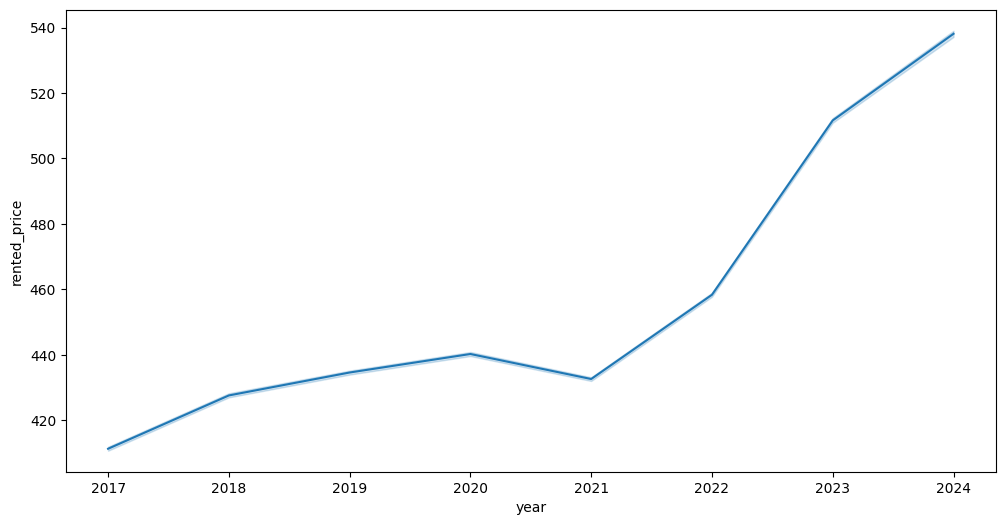

In [5]:
# plt the graph between rented price vs year
plt.figure(figsize=(12, 6))
sns.lineplot(data=rental_df, x='year', y='rented_price')

As the graphs shows a big difference between precovid and post covid, we will only be considering data from year 2021

In [113]:
rental_df.drop_duplicates(inplace=True)

In [116]:
rental_df = rental_df[rental_df["year"] >=2021]

year 2021 and 2022 will be used for training and year 2023 and 2024 will be used for testing

In [118]:
hist_df = rental_df[
    (rental_df['year'] >= 2021) &
    (rental_df['year'] <= 2023)
]
curr_df = rental_df[
    (rental_df['year'] > 2023) &
    (rental_df['year'] <= 2024)
]

In [119]:
# parition curr and hist dataframes based on type: 'House' and 'Unit/apmt'
hist_house_df = hist_df[hist_df['type'] == 'House']
hist_unit_df = hist_df[hist_df['type'] == 'Unit/apmt']
curr_house_df = curr_df[curr_df['type'] == 'House']
curr_unit_df = curr_df[curr_df['type'] == 'Unit/apmt']

# drop 'type' column
hist_house_df.drop(columns=['type'], inplace=True)
hist_unit_df.drop(columns=['type'], inplace=True)
curr_house_df.drop(columns=['type'], inplace=True)
curr_unit_df.drop(columns=['type'], inplace=True)

# print the shape of each dataframe
print('hist_house_df:', hist_house_df.shape)
print('hist_unit_df:', hist_unit_df.shape)
print('curr_house_df:', curr_house_df.shape)
print('curr_unit_df:', curr_unit_df.shape)

hist_house_df: (152132, 13)
hist_unit_df: (260605, 13)
curr_house_df: (26782, 13)
curr_unit_df: (51166, 13)


/tmp/ipykernel_55500/4217374014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_house_df.drop(columns=['type'], inplace=True)
/tmp/ipykernel_55500/4217374014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_unit_df.drop(columns=['type'], inplace=True)
/tmp/ipykernel_55500/4217374014.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_house_df.drop(columns=['type'], inplace=True)
/tmp/ipykernel_55500/4217374014.py

In [10]:
# remove irregular data

hist_house_df = hist_house_df[hist_house_df["bath"] < 5]
curr_house_df = curr_house_df[curr_house_df["bath"] < 5]

In [11]:
MIN_INSTANCES_PER_SUBURB = 100

In [12]:
# find the number of suburbs with more than 1000 instances
hist_house_df['count'] = hist_house_df.groupby('suburb')['suburb'].transform('count')
hist_house_df[hist_house_df['count'] >= MIN_INSTANCES_PER_SUBURB]['suburb'].nunique()

hist_unit_df['count'] = hist_unit_df.groupby('suburb')['suburb'].transform('count')

curr_house_df['count'] = curr_house_df.groupby('suburb')['suburb'].transform('count')
curr_unit_df['count'] = curr_unit_df.groupby('suburb')['suburb'].transform('count')


/tmp/ipykernel_55500/2247219211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_unit_df['count'] = hist_unit_df.groupby('suburb')['suburb'].transform('count')
/tmp/ipykernel_55500/2247219211.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_unit_df['count'] = curr_unit_df.groupby('suburb')['suburb'].transform('count')


In [13]:


# add a new column which is the count of the entries within that suburb

high_confidence_unit_hist = hist_unit_df[hist_unit_df['count'] >= MIN_INSTANCES_PER_SUBURB]
high_confidence_house_hist = hist_house_df[hist_house_df['count'] >= MIN_INSTANCES_PER_SUBURB]

low_confidence_unit_hist = hist_unit_df[hist_unit_df['count'] < MIN_INSTANCES_PER_SUBURB]
low_confidence_house_hist = hist_house_df[hist_house_df['count'] < MIN_INSTANCES_PER_SUBURB]

high_unit_confidence_suburb = high_confidence_unit_hist['suburb'].unique()
low_unit_confidence_suburb = low_confidence_unit_hist['suburb'].unique()

high_house_confidence_suburb = high_confidence_house_hist['suburb'].unique()
low_house_confidence_suburb = low_confidence_house_hist['suburb'].unique()

In [14]:
high_confidence_house_curr = curr_house_df[curr_house_df['suburb'].isin(high_house_confidence_suburb)]
low_confidence_house_curr = curr_house_df[curr_house_df['suburb'].isin(low_house_confidence_suburb)]

high_confidence_house_curr = high_confidence_house_curr[high_confidence_house_curr['rented_price']>300]
low_confidence_house_curr = low_confidence_house_curr[low_confidence_house_curr['rented_price']>300]

high_confidence_unit_curr = curr_unit_df[curr_unit_df['suburb'].isin(high_unit_confidence_suburb)]
low_confidence_unit_curr = curr_unit_df[curr_unit_df['suburb'].isin(low_unit_confidence_suburb)]

high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['rented_price']>200]
low_confidence_house_curr = low_confidence_house_curr[low_confidence_house_curr['rented_price']>200]

In [15]:
numeric_features = ['bed, bath, car, year, median_income, population, cpi, unemployment_rate, time_city', 'avg_property_price',"count"]

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Defining the ColumnTransformer for one-hot encoding 'type' and standardizing numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

def run_0R(X_train, X_test, y_train):
    zero_r_model = DummyRegressor(strategy='mean')
    zero_r_model.fit(X_train, y_train)
    # print training score
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {zero_r_model.score(X_train, y_train)}")
    return zero_r_model.predict(X_test)

def run_LR(X_train, X_test, y_train):
    # Initialize and fit the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Get the predicted values
    predictions = lr_model.predict(X_test)
    
    # Extract the model coefficients
    coef = lr_model.coef_
    
    # Create a DataFrame to pair feature names with their corresponding coefficients
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coef
    })
    
    # Sort the DataFrame by the absolute value of the coefficients (most relevant feature first)
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Display the most relevant features (sorted by the coefficient's absolute value)
    
    
    return predictions,feature_importance

def run_RF(X_train, X_test, y_train):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=5, min_samples_split=5)
    rf_model.fit(X_train, y_train)

    return rf_model.predict(X_test)

def run_MLP(X_train, X_test, y_train):
    mlp_model = MLPRegressor(random_state=1, max_iter=300)
    mlp_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {mlp_model.score(X_train, y_train)}")
    return mlp_model.predict(X_test)

def run_KNN(X_train, X_test, y_train):
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {knn_model.score(X_train, y_train)}")
    return knn_model.predict(X_test)

def run_SVR(X_train, X_test, y_train):
    from sklearn.svm import SVR
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {svr_model.score(X_train, y_train)}")
    return svr_model.predict(X_test)

def run_combine_models(X_train, X_test, y_train, weight_lr=0.5, weight_rf=0.5):
    # Ensure weights sum to 1
    assert weight_lr + weight_rf == 1, "The sum of the weights should be 1."
    
    # --- Linear Regression ---
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    
    # Extract the model coefficients for LR
    coef = lr_model.coef_
    feature_importance_lr = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coef
    })
    feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()
    feature_importance_lr = feature_importance_lr.sort_values(by='Abs_Coefficient', ascending=False)

    # --- Random Forest ---
    rf_model = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=5, min_samples_split=5)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    # Combine predictions by averaging (weighted average can be applied)
    combined_predictions = (weight_lr * lr_predictions) + (weight_rf * rf_predictions)

    # You can choose to return the feature importances for both models or just LR
    return combined_predictions, feature_importance_lr



def display_metrics(y_test, y_pred_zero_r,y_pred_lr,y_pred_rf):
    # Compute evaluation metrics for ZeroR
    mse_zero_r = mean_squared_error(y_test, y_pred_zero_r)
    r2_zero_r = r2_score(y_test, y_pred_zero_r)
    # Compute evaluation metrics for Linear Regression
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    # Compute evaluation metrics for Random Forest
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    # get variance of the target variable
    variance = y_test.var()      
    # Output the results
    print("ZeroR (Baseline) Model")
    print(f"Mean Squared Error (MSE): {mse_zero_r}")
    print(f"R-Squared (R2 Score): {r2_zero_r}\n")
    print("Linear Regression Model")
    print(f"Mean Squared Error (MSE): {mse_lr}")
    print(f"R-Squared (R2 Score): {r2_lr}\n")
    print("Random Forest Model")
    print(f"Mean Squared Error (MSE): {mse_rf}")
    print(f"R-Squared (R2 Score): {r2_rf}")
    print(f"Variance of the target variable: {variance}")

In [83]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

def model_and_predict(df1, future_df):
    Prior_2021 = df1
    # set intersection of suburbs in the future data and the training data
    suburb_testing = set(future_df['suburb'].unique().tolist()).intersection(set(Prior_2021['suburb'].unique().tolist()))
    list_future_df = []
    missing_suburbs = []
    print("Suburbs to predict: ", len(suburb_testing))
    for i in tqdm(suburb_testing):
        # Filter the data by suburb
        Prior_2021_suburb = Prior_2021[Prior_2021['suburb'] == i]
        if Prior_2021_suburb.shape[0] == 0:
            missing_suburbs.append(i)
            continue
        X_train = Prior_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code','count'])
        y_train = Prior_2021_suburb['rented_price']
        
        col_names = X_train.columns
        
        xy_future = future_df[future_df['suburb'] == i].copy()
        x_future = xy_future.drop(columns=[ 'suburb','rented_price'])
        x_future = x_future.reindex(col_names, axis=1)

        # future prediction
        if not x_future.empty:
            xy_future.loc[:,'pred_0r'] = run_0R(X_train, x_future, y_train)
            xy_future.loc[:,'pred_lr'],_ = run_LR(X_train, x_future, y_train)
            xy_future.loc[:,'pred_rf'] = run_RF(X_train, x_future, y_train)
            xy_future.loc[:,'pred_combine'],_ = run_combine_models(X_train, x_future, y_train, weight_lr=0.5, weight_rf=0.5)
        else:
            tqdm.write(f"Suburb {i} has no future data")
            xy_future.loc[:,'pred_0r'] = np.nan
            xy_future.loc[:,'pred_lr'] = np.nan
            xy_future.loc[:,'pred_rf'] = np.nan
            xy_future.loc[:,'pred_combine'] = np.nan
            
        list_future_df.append(xy_future)
    return pd.concat(list_future_df), missing_suburbs
    
    
def modeling(df1, df2, future_df):
    Prior_2021 = df1
    After_2021 = df2

    suburb_testing = future_df['suburb'].unique()
    
    # Initialize lists to collect results
    average_mse_zero_r = []
    average_mse_lr = []
    average_mse_rf = []
    average_r2_combine = []
    
    bad_prediction = []
    good_prediction = []
    
    # Initialize dictionary to aggregate feature importances across all suburbs
    feature_importance_sum = pd.DataFrame()
    list_future_df = []
    # Loop over all suburbs
    for i in tqdm(suburb_testing):
        # Filter the data by suburb
        Prior_2021_suburb = Prior_2021[Prior_2021['suburb'] == i]
        After_2021_suburb = After_2021[After_2021['suburb'] == i]

        X_train = Prior_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code','count'])
        X_test = After_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code','count'])
        y_train = Prior_2021_suburb['rented_price']
        y_test = After_2021_suburb['rented_price']
        
        col_names = X_train.columns
        
        xy_future = future_df[future_df['suburb'] == i]
        x_future = xy_future.drop(columns=[ 'suburb','rented_price'])
        x_future = x_future.reindex(col_names, axis=1)
        
        # Run the models
        y_pred_zero_r = run_0R(X_train, X_test, y_train)
        y_pred_lr, feature_importance = run_LR(X_train, X_test, y_train)
        y_pred_rf = run_RF(X_train, X_test, y_train)
        y_pred_combine, _ = run_combine_models(X_train, X_test, y_train, weight_lr=0.5, weight_rf=0.5)
        # future prediction
        if not x_future.empty:
            xy_future['pred_0r'] = run_0R(X_train, x_future, y_train)
            xy_future['pred_lr'],_ = run_LR(X_train, x_future, y_train)
            xy_future['pred_rf'] = run_RF(X_train, x_future, y_train)
            xy_future['pred_combine'],_ = run_combine_models(X_train, x_future, y_train, weight_lr=0.5, weight_rf=0.5)
        else:
            xy_future['pred_0r'] = np.nan
            xy_future['pred_lr'] = np.nan
            xy_future['pred_rf'] = np.nan
            xy_future['pred_combine'] = np.nan
            
        list_future_df.append(xy_future)
        
        # Calculate R2 scores
        r2_lr = r2_score(y_test, y_pred_lr)
        r2_rf = r2_score(y_test, y_pred_rf)
        r2_combine = r2_score(y_test, y_pred_combine)

        # Store the R2 results for analysis
        average_mse_zero_r.append(r2_score(y_test, y_pred_zero_r))
        average_mse_lr.append(r2_lr)
        average_mse_rf.append(r2_rf)
        average_r2_combine.append(r2_combine)
        
        # Sum up feature importances across suburbs for LR
        if feature_importance_sum.empty:
            feature_importance_sum = feature_importance.set_index('Feature')
        else:
            feature_importance_sum['Coefficient'] += feature_importance.set_index('Feature')['Coefficient']

    # Remove negative R2 values
    average_mse_lr = [x for x in average_mse_lr if x >= 0]
    average_mse_rf = [x for x in average_mse_rf if x >= 0] 
    average_r2_combine = [x for x in average_r2_combine if x >= 0]
    
    # Print average R2 scores for LR, RF, and Combined
    print('Average R2 Score LR:', np.mean(average_mse_lr))
    print('Average R2 Score RF:', np.mean(average_mse_rf))
    print('Average R2 Score Combined:', np.mean(average_r2_combine))
    
    # Print bad and good predictions if applicable
    # print(bad_prediction)
    # print(good_prediction)

    # Find the top 5 most important features overall (based on summed coefficients from LR)
    feature_importance_sum['Abs_Coefficient'] = feature_importance_sum['Coefficient'].abs()
    top_5_features = feature_importance_sum.sort_values(by='Abs_Coefficient', ascending=False).head(5)

    # Print the top 5 most important features
    print("Top 5 most important features across all suburbs:")
    print(top_5_features[['Coefficient', 'Abs_Coefficient']])
    return pd.concat(list_future_df)


# Modelling high confidnece house

In [17]:


# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Loop over the years and plot each year's distribution in a separate subplot
# for idx, i in enumerate(range(2017, 2025)):
#     wyndham_vale = rental_df[(rental_df['suburb'] == 'BALLARAT CENTRAL') & (rental_df['year'] == i)]
#     sns.histplot(wyndham_vale["rented_price"], kde=True, bins=30, ax=axes[idx])
#     axes[idx].set_title(f'MELBOURNE Rented Price Distribution in {i}')
#     axes[idx].set_xlabel('Rented Price')
#     axes[idx].set_ylabel('Frequency')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

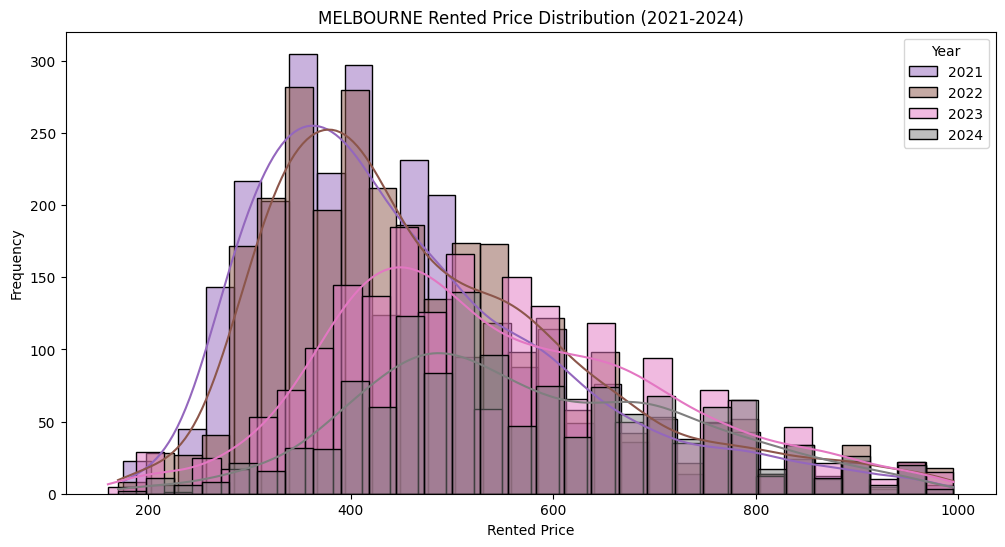

In [18]:
# Create a figure for the combined plot
plt.figure(figsize=(12, 6))

# Loop over the years and plot each year's distribution on the same figure
for i in range(2017, 2025):
    wyndham_vale = rental_df[(rental_df['suburb'] == 'SOUTH YARRA') & (rental_df['year'] == i)]
    sns.histplot(wyndham_vale["rented_price"], kde=True, label=f'{i}', bins=30)

# Add title and labels
plt.title('MELBOURNE Rented Price Distribution (2021-2024)')
plt.xlabel('Rented Price')
plt.ylabel('Frequency')

# Show the legend
plt.legend(title='Year')

# Display the plot
plt.show()

## house

In [19]:
high_confidence_house_hist

,suburb,sa2_code,year,bed,bath,car,median_income,population,cpi,unemployment_rate,time_city,avg_property_price,rented_price,count
205,IVANHOE,209011200,2023,3.0,2.0,1.0,71497.232833,12924.0,5.6,3.691667,1315.9,5.222656e+05,600,157
206,IVANHOE,209011200,2023,3.0,2.0,1.0,71497.232833,12924.0,5.6,3.691667,1315.9,5.222656e+05,640,157
207,IVANHOE,209011200,2022,3.0,2.0,1.0,68916.022275,12588.0,7.8,3.611111,1315.9,1.218332e+06,600,157
208,IVANHOE,209011200,2021,3.0,2.0,1.0,68490.000000,12559.0,3.5,4.200000,1315.9,7.887445e+05,620,157
217,IVANHOE,209011200,2023,4.0,2.0,4.0,71497.232833,12924.0,5.6,3.691667,1371.9,5.222656e+05,795,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316800,DANDENONG,212041564,2023,2.0,2.0,1.0,48649.488311,9826.0,5.6,3.691667,2188.3,5.462254e+05,440,838
1316840,DANDENONG,212041563,2023,3.0,1.0,1.0,47766.044291,22193.0,5.6,3.691667,1914.7,5.462254e+05,450,838
1316900,DANDENONG,212041563,2023,2.0,1.0,1.0,47766.044291,22193.0,5.6,3.691667,1880.8,5.462254e+05,340,838
1316901,DANDENONG,212041563,2022,2.0,1.0,1.0,47120.763011,21384.0,7.8,3.611111,1880.8,5.237105e+05,340,838


In [20]:
df1 = high_confidence_house_hist
df2 = high_confidence_house_curr

In [84]:
predict_house_high, missing_house_high = model_and_predict(high_confidence_house_hist,data_future_house)
predict_house_high['confidence'] = 'high'

100%|██████████| 281/281 [00:53<00:00,  5.27it/s]


In [86]:
predict_house_high.shape, missing_house_high

((843, 17), [])

# Modelling high confidence unit/apmt

In [22]:
# bathroom should be less than 2

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['bath'] <= 2]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['bath'] <= 2]

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['bath'] > 0]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['bath'] > 0]

# car park should be less than 3

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['car'] <= 3]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['car'] <= 3]

# eliminate apartment with more than 1400 per week

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['rented_price'] <= 1400]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['rented_price'] <= 1400]

In [90]:
df1 = high_confidence_unit_hist
df2 = high_confidence_unit_curr

predict_unit_high, missing_unit_high = model_and_predict(df1, data_future_unit)
predict_unit_high['confidence'] = 'high'

Suburbs to predict:  286


100%|██████████| 286/286 [01:03<00:00,  4.50it/s]


In [26]:
# # taking Melbourne city as an example to observe the model performance

# Melbourne_train = high_confidence_unit_hist[high_confidence_unit_hist['suburb'] == 'MELBOURNE']
# Melbourne_test = high_confidence_unit_curr[high_confidence_unit_curr['suburb'] == 'MELBOURNE']

# X_train = Melbourne_train.drop(columns=['rented_price','suburb','sa2_code'])
# X_test = Melbourne_test.drop(columns=['rented_price','suburb','sa2_code'])
# y_train = Melbourne_train['rented_price']
# y_test = Melbourne_test['rented_price']


# def run_RF(X_train, X_test, y_train):
#     rf_model = RandomForestRegressor(n_estimators=150, random_state=1, max_depth=5)
#     rf_model.fit(X_train, y_train)
#     #print("ZeroR (Baseline) Model")
#     # print important features
#     importances = rf_model.feature_importances_
#     feature_names = X_train.columns  # If X_train is a pandas DataFrame
#     feature_importance_df = pd.DataFrame({
#         'Feature': feature_names,
#         'Importance': importances
#     })
#     feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#     # print(feature_importance_df.head())  # Display the top features

#     return rf_model.predict(X_test)

# def run_logistic(X_train, X_test, y_train):
#     from sklearn.linear_model import LogisticRegression
#     logistic_model = LogisticRegression(random_state=1)
#     logistic_model.fit(X_train, y_train)
#     #print("ZeroR (Baseline) Model")
#     #print(f"Training Score: {logistic_model.score(X_train, y_train)}")
#     return logistic_model.predict(X_test)

# def run_ridge(X_train, X_test, y_train):
#     from sklearn.linear_model import Ridge
#     ridge_model = Ridge(alpha=1.0)
#     ridge_model.fit(X_train, y_train)
#     #print("ZeroR (Baseline) Model")
#     #print(f"Training Score: {ridge_model.score(X_train, y_train)}")
#     return ridge_model.predict(X_test)

# y_pred_rf = run_RF(X_train, X_test, y_train)
# y_pred_ridge = run_ridge(X_train, X_test, y_train)


# r2_rf = r2_score(y_test, y_pred_rf)
# r2_ridge = r2_score(y_test, y_pred_ridge)


# print(r2_rf,r2_ridge)
# Melbourne_test

0.3688890786507205 0.2921305929538133


,suburb,sa2_code,year,bed,bath,car,median_income,population,cpi,unemployment_rate,time_city,avg_property_price,rented_price,count
1317392,MELBOURNE,206041505,2024,2.0,2.0,1.0,42430.858339,20162.0,3.53,4.014286,263.3,696152.566964,730,3781
1317393,MELBOURNE,206041505,2024,2.0,1.0,0.0,42430.858339,20162.0,3.53,4.014286,232.5,696152.566964,720,3781
1317394,MELBOURNE,206041505,2024,2.0,2.0,1.0,42430.858339,20162.0,3.53,4.014286,228.1,696152.566964,800,3781
1317395,MELBOURNE,206041503,2024,2.0,2.0,0.0,42412.280478,11840.0,3.53,4.014286,124.0,696152.566964,840,3781
1317396,MELBOURNE,206051514,2024,2.0,2.0,1.0,66910.824282,15041.0,3.53,4.014286,650.5,696152.566964,680,3781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408454,MELBOURNE,206041505,2024,2.0,2.0,0.0,42430.858339,20162.0,3.53,4.014286,156.4,696152.566964,820,3781
1408455,MELBOURNE,206041503,2024,1.0,1.0,0.0,42412.280478,11840.0,3.53,4.014286,168.9,696152.566964,270,3781
1408457,MELBOURNE,206041504,2024,1.0,1.0,0.0,37039.553272,22750.0,3.53,4.014286,208.5,696152.566964,470,3781
1408458,MELBOURNE,206041503,2024,2.0,1.0,1.0,42412.280478,11840.0,3.53,4.014286,158.1,696152.566964,600,3781


# Modelling low confidence house

In [87]:
df1 = low_confidence_unit_hist
df2 = low_confidence_unit_curr
predict_house_low, missing_house_low = model_and_predict(df1,data_future_house)
predict_house_low['confidence'] = 'low'

Suburbs to predict:  494


100%|██████████| 494/494 [00:59<00:00,  8.26it/s]


In [ ]:
predict_house_low.shape, missing_house_low

# Modelling low confidence unit/apmt

In [89]:
df1 = low_confidence_house_hist
df2 = low_confidence_house_curr
predict_unit_low,missing_unit_low = model_and_predict(df1,data_future_unit)
predict_unit_low['confidence'] = 'low'

Suburbs to predict:  527


100%|██████████| 527/527 [01:04<00:00,  8.13it/s]


<Axes: >

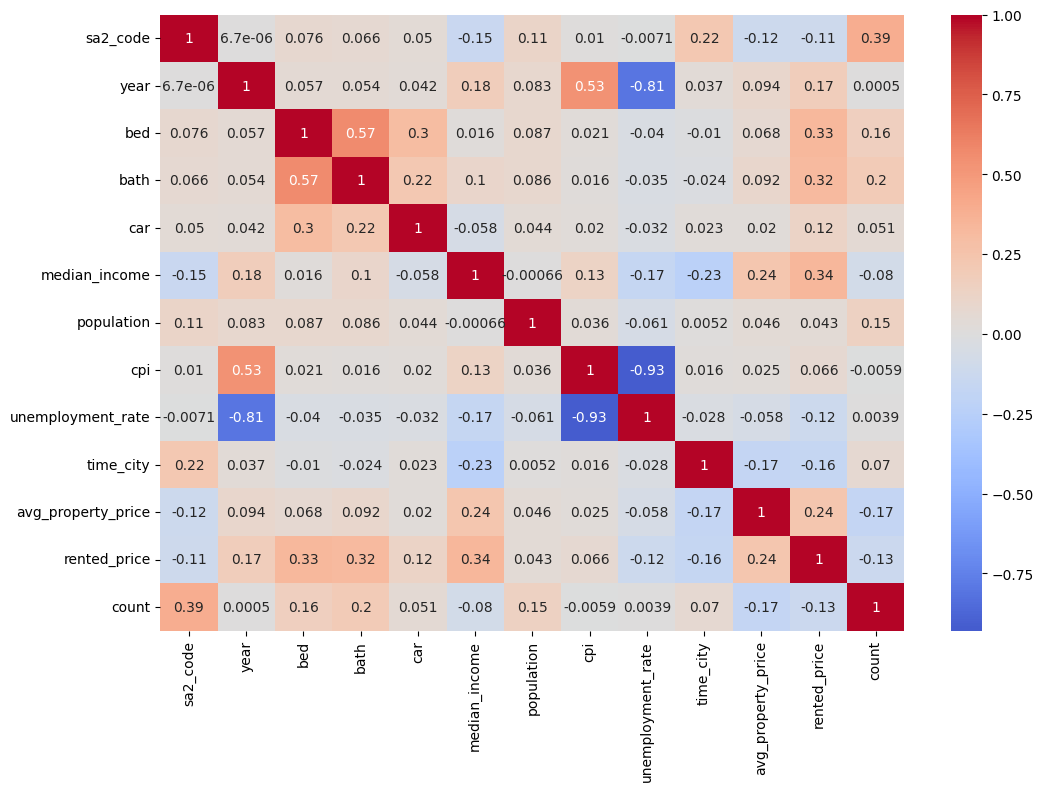

In [29]:
# plot a correlation map between all variables
plt.figure(figsize=(12, 8))
sns.heatmap(high_confidence_house_hist.drop(columns=["suburb"]).corr(), annot=True, cmap='coolwarm', center=0)

# combine predict dataset

In [160]:
house_sub = predict_house_high['suburb'].unique().tolist()
predict_house_low = predict_house_low[~predict_house_low['suburb'].isin(house_sub)]
predict_house = pd.concat([predict_house_high, predict_house_low])
predict_house.sort_index(inplace=True)
predict_house.to_csv("../data/curated/predict_house.csv", index=False)

In [163]:
unit_sub  = predict_unit_high['suburb'].unique().tolist()
predict_unit_low = predict_unit_low[~predict_unit_low['suburb'].isin(unit_sub)]
predict_unit = pd.concat([predict_unit_high, predict_unit_low])
predict_unit.sort_index(inplace=True)
predict_unit.to_csv("../data/czurated/predict_unit.csv", index=False)

count how many suburbs processed

In [93]:
suburb_l = sorted(hist_unit_df['suburb'].unique().tolist())

In [97]:
missing_suburb = []
for subrub in data_future_house['suburb'].unique():
    if subrub not in predict_house['suburb'].unique():
        missing_suburb.append(subrub)

In [98]:
len(missing_suburb)

405

In [99]:
in_both = []
not_both = []
for subrub in missing_suburb:
    if subrub in suburb_l:
        in_both.append(subrub)
    else:
        not_both.append(subrub)


In [100]:
temp = hist_house_df[hist_house_df['suburb'].isin(in_both)]
temp.groupby('suburb')['suburb'].count().sort_index()


suburb
ALPHINGTON          89
BALACLAVA           61
BLACK ROCK          73
BONBEACH            98
BROWN HILL          95
CAMPBELLFIELD       85
CARRUM              72
CAULFIELD           64
CREMORNE            39
DAYLESFORD          60
DOCKLANDS           48
EAGLEMONT           48
ESSENDON WEST       24
EUMEMMERRING        62
GARDENVALE           7
GLEN HUNTLY         43
HAMPTON EAST        95
HERNE HILL          94
IVANHOE EAST        37
LAKE WENDOUREE      81
LOWER PLENTY        30
MAFFRA              50
MANIFOLD HEIGHTS    50
MANSFIELD           81
MIDDLE PARK         98
MONT ALBERT         82
NEWBOROUGH          90
NEWINGTON           72
POINT LONSDALE      77
SANDRINGHAM         95
SKYE                99
SOMERVILLE          76
SOUTH KINGSVILLE    87
SOUTHBANK           93
ST KILDA WEST       37
TRAVANCORE          32
VIEWBANK            86
WERRIBEE SOUTH      89
WHITTINGTON         80
Name: suburb, dtype: int64